In [ ]:
import os
import sys

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))


In [1]:
import json
import math
from collections import namedtuple
from typing import Any, Dict, List

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm.notebook import tqdm, tnrange
from numpy import typing as npt
from tensorflow import keras
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

from src import ROOT_DIR


In [2]:
def load_glow(hps_path: str):
    hps: Dict[str, Any]
    with open(hps_path, "r") as json_file:
        hps = json.load(json_file)

    coupling = None
    if self.hps["COUPLING_BIJECTOR_FN"] in ["GlowDefaultNetwork", "tfb.GlowDefaultNetwork"]:
        coupling = tfb.GlowDefaultNetwork
    elif self.hps["COUPLING_BIJECTOR_FN"] == "GlowAdditiveNetwork":
        coupling = GlowAdditiveNetwork

    glow = tfb.Glow(
        output_shape=hps["OUTPUT_SHAPE"],
        num_glow_blocks=hps["NUM_GLOW_BLOCKS"],
        num_steps_per_block=hps["NUM_STEPS_PER_BLOCK"],
        coupling_bijector_fn=coupling,
        exit_bijector_fn=tfb.GlowDefaultExitNetwork,
        grab_after_block=hps["GRAB_AFTER_BLOCK"],
        use_actnorm=hps["USE_ACTNORM"],
        seed=hps["SEED"],
        validate_args=True,
    )

    z_shape = glow.inverse_event_shape(hps["OUTPUT_SHAPE"])
    pz = tfd.Sample(tfd.Normal(0.0, 1.0), z_shape)
    px = glow(pz)

    checkpoint = tf.train.Checkpoint(glow)

    safe_path = hps_path.replace("hyperparameters.json", "", 1)
    checkpoint_path = f"{safe_path}/checkpoints/ckpt-{math.floor(self.hps['EPOCHS'] / self.hps['CHECKPOINT_FREQ']) + 1}"
    status = checkpoint.restore(checkpoint_path)
    status.assert_consumed().assert_existing_objects_matched().assert_nontrivial_match()

    print(f"Loaded: {checkpoint_path}")

    return glow, pz, px, hps


In [4]:
glow, pz, px, hps = load_glow(
    f"{ROOT_DIR}/glow/safe/128-2_2022-09-20_17:36:27/hyperparameters.json"
)


Loaded: /home/lukas/HESSENBOX-DA/Bachelor-Thesis/Ergebnisse/TFP GLOW/128-2_2022-09-20_17:36:27/checkpoints/ckpt-11


In [5]:
def load_image(path: str) -> tf.Tensor:
    return tf.convert_to_tensor(keras.utils.img_to_array(keras.utils.load_img(path)))


In [6]:
def preprocess(tensor: tf.Tensor) -> tf.Tensor:
    tensor = tf.cast(tensor, tf.float32)
    tensor = tf.image.central_crop(tensor, hps["CENTRAL_CROP_FRACTION"])
    tensor = tf.image.resize(tensor, (hps["IMAGE_SIZE"], hps["IMAGE_SIZE"]))

    tensor = tensor / 255 - 0.5
    return tensor


In [7]:
def depreprocess(tensor: tf.Tensor) -> tf.Tensor:
    return tf.clip_by_value(tensor + 0.5, 0.0, 1.0)


In [9]:
img1 = load_image(f"{ROOT_DIR}/data/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0002_36648.jpg")
img1 = preprocess(img1)

img2 = load_image(f"{ROOT_DIR}/data/Bird/Cardinalidae/Blue_Grosbeak/Blue_Grosbeak_0014_36708.jpg")
img2 = preprocess(img2)

img3 = load_image(f"{ROOT_DIR}/data/Bird/Icteridae/Scott_Oriole/Scott_Oriole_0010_795852.jpg")
img3 = preprocess(img3)

img4 = load_image(f"{ROOT_DIR}/data/Bird/Icteridae/Bobolink/Bobolink_0049_9540.jpg")
img4 = preprocess(img4)


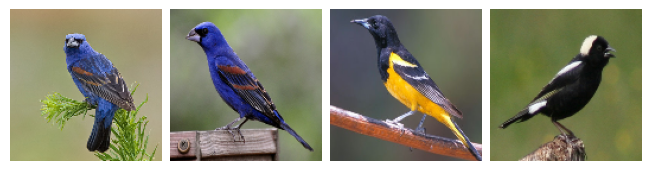

In [10]:
fig, axs = plt.subplots(1, 4, dpi=100, constrained_layout=True)

for img, ax in zip([img1, img2, img3, img4], axs):
    ax.imshow(depreprocess(img))
    ax.set_axis_off()

plt.show()


In [11]:
def interpolate(img1, img2, n):
    interpolations = []

    z1, z2 = glow.inverse(tf.stack((img1, img2)))

    vec = z2 - z1

    for i in tnrange(n):
        t = z1 + (i / (n - 1)) * vec
        t = glow(tf.expand_dims(t, 0))
        interpolations.append(t)

    return interpolations


In [12]:
def interpolate_pixel(img1, img2, n):
    interpolations = []

    vec = img2 - img1

    for i in tnrange(n):
        t = img1 + (i / (n - 1)) * vec
        interpolations.append(t)

    return interpolations


  0%|          | 0/5 [00:00<?, ?it/s]

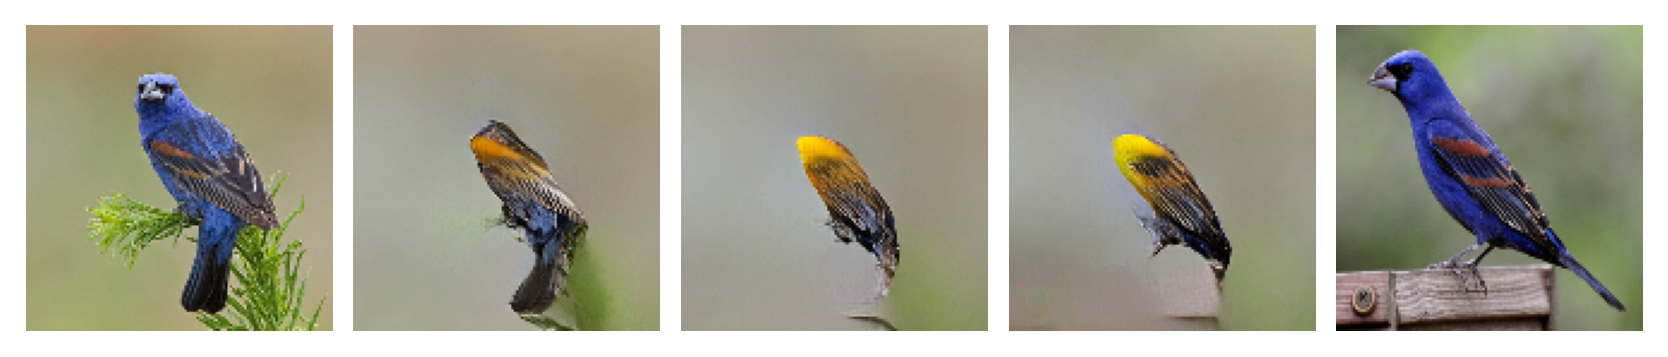

In [13]:
n = 5
interpolations = interpolate(img1, img2, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i][0]))
    axs[i].set_axis_off()

plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

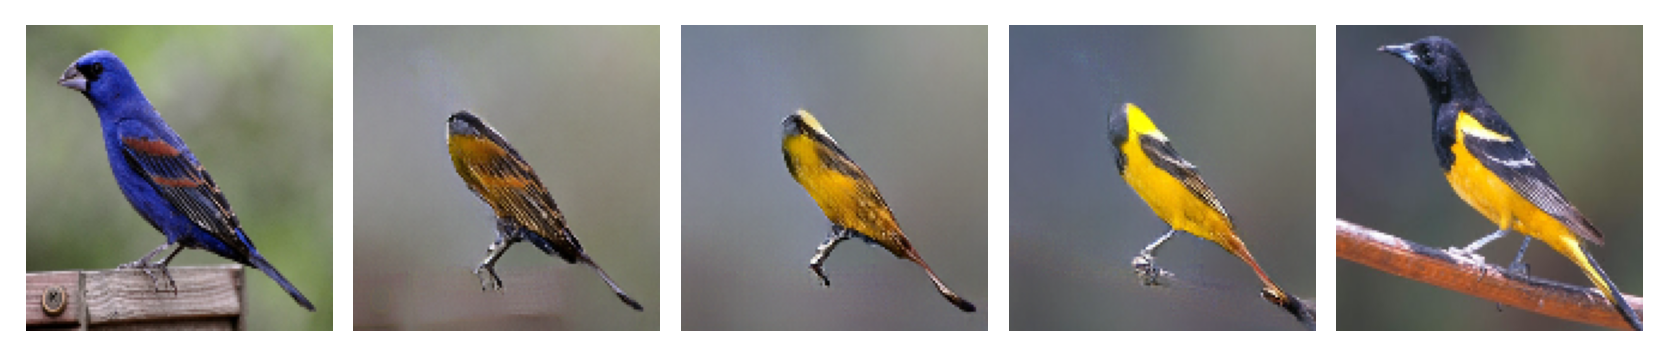

In [14]:
n = 5
interpolations = interpolate(img2, img3, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i][0]))
    axs[i].set_axis_off()

plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

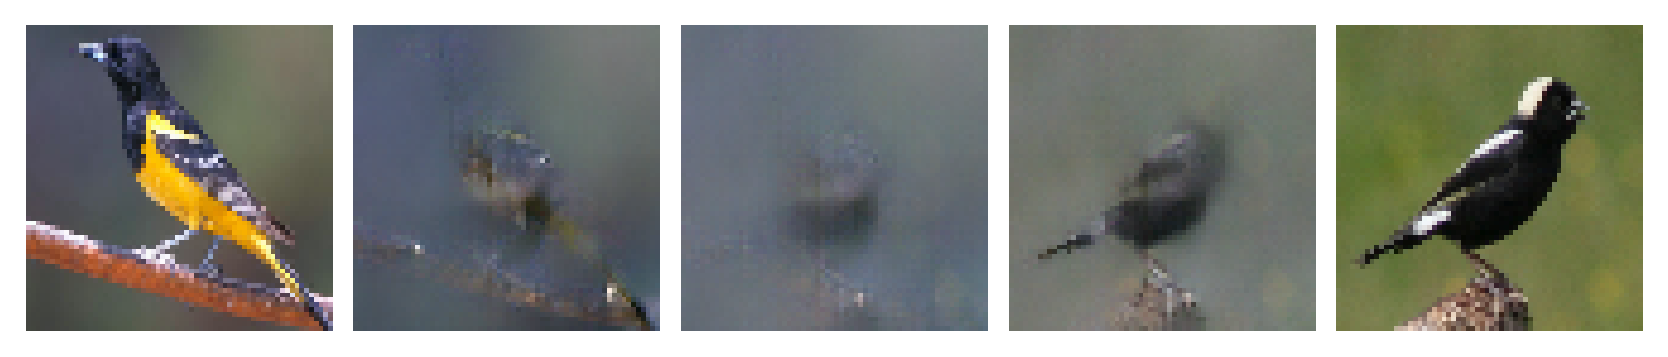

In [13]:
n = 5
interpolations = interpolate(img3, img4, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i][0]))
    axs[i].set_axis_off()

plt.show()


  0%|          | 0/7 [00:00<?, ?it/s]

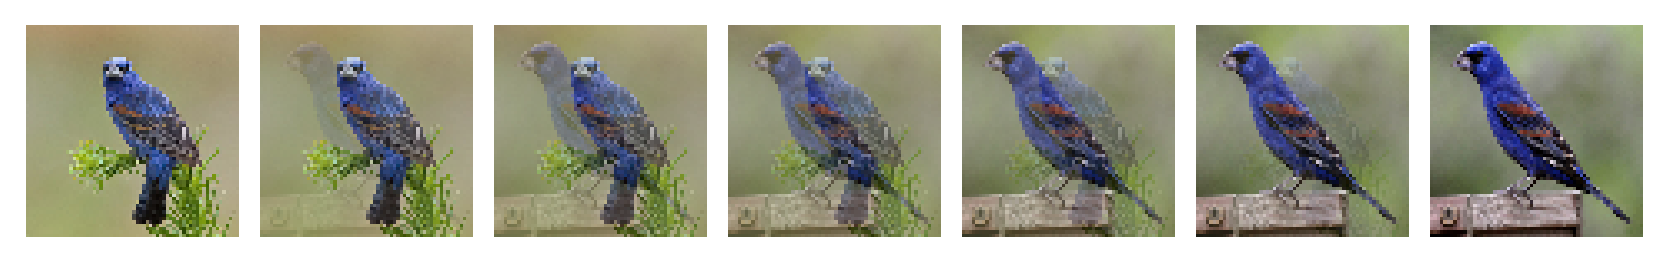

In [14]:
n = 7
interpolations = interpolate_pixel(img1, img2, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i]))
    axs[i].set_axis_off()

plt.show()


  0%|          | 0/7 [00:00<?, ?it/s]

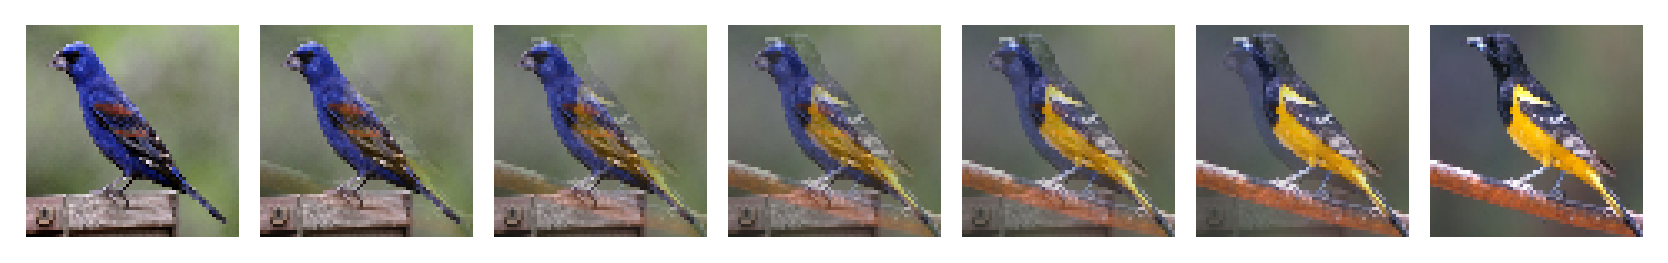

In [15]:
n = 7
interpolations = interpolate_pixel(img2, img3, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i]))
    axs[i].set_axis_off()

plt.show()


  0%|          | 0/7 [00:00<?, ?it/s]

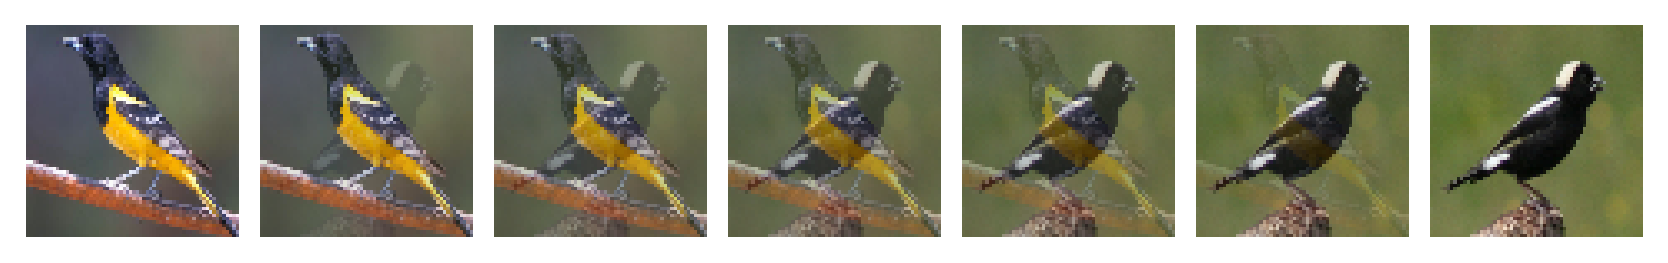

In [16]:
n = 7
interpolations = interpolate_pixel(img3, img4, n)

fig, axs = plt.subplots(1, n, dpi=200, constrained_layout=True)

for i in range(n):
    axs[i].imshow(depreprocess(interpolations[i]))
    axs[i].set_axis_off()

plt.show()
